# The Deep DRT: A Neural Network Approach to Deconvolve the Distribution of Relaxation Times (DRT)

In this tutorial we will reproduce Figures S15 and S16 right side of the article at the DOI https://doi.org/10.1016/j.electacta.2021.139010

This tutorial shows how the deep-DRT model can manage DRT with discontinuities where the impedance was generated using the PWC element.

In [1]:
import os
import numpy as np
import compute_DRT
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi, sin, cos, sqrt, log
import importlib
importlib.reload(compute_DRT)

<module 'compute_DRT' from 'C:\\Users\\user\\AACODE\\DEEP_DRT\\deep-DRT\\tutorials\\compute_DRT.py'>

## 1) Piecewise constant model

The impedance of the PWC model, using a 2D deep DRT model (i.e., one state variable $\psi$) is given by:

$$
Z_{ \rm exact}(f,\psi) = R_{\infty}+\displaystyle \frac{R_{\rm ct}(\psi)}{ {\rm log} \left(\displaystyle \frac {\tau_1(\psi)}{\tau_0(\psi)}\right)}\left({ \rm log} \left (1-\displaystyle \frac{i}{2 \pi f \tau_0(\psi)} \right)-{ \rm log}\left(1-\displaystyle \frac{i}{2 \pi f \tau_1(\psi )}\right)\right)
$$





The corresponding analytical formula for the DRT is:

$$
\gamma(\log \tau, \psi) = \displaystyle \frac{R_{\rm ct}(\psi)}{ {\rm log} \left(\displaystyle \frac {\tau_1(\psi)}{\tau_0(\psi)}\right)} \left (H\left(\tau - \tau_0(\psi)\right)-H\left(\tau - \tau_0(\psi)\right) \right)
$$

## 1.2) Frequencies and timescales range

In [2]:
# seed for reproducibility
torch.manual_seed(213912)

Tensor = torch.FloatTensor

# define frequency range
log_freq_min = -4.
log_freq_max = 4.
N_freqs = 10*int(log_freq_max-log_freq_min)+1
freq_vec = np.logspace(log_freq_min, log_freq_max, num=N_freqs, endpoint=True).reshape(N_freqs,1)

# define tau range
log_tau_min = -log_freq_max
log_tau_max = -log_freq_min
N_taus = 10*int(log_tau_max-log_tau_min)+1
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True).reshape(N_taus,1)

# the ANN will take the normalized log10 of the tau vector as input
log_tau_vec = np.log(tau_vec)
log_tau_vec_norm = -1.+2.*(log_tau_vec-log_tau_vec.min())/(log_tau_vec.max()-log_tau_vec.min())

## 1.3) Parameter of PWC model

In [3]:
# data for the exact impedance
R_inf = 10.
R_ct_0 = 50.
tau_1 = 1E1
tau_2 =1E-1

sigma_n_exp_0 = 1. 

# declare lists that store:
# 1) data
freq_vec_list = []
Z_re_list = []
Z_im_list = []
gamma_exact_list = []
Z_re_exact_list = []
Z_im_exact_list = []

## 2) Artificial experiments generation and DNN input

In [ ]:
# 2) DRT-to-impedance and derivative matrices
A_re_list = []
A_im_list = []
L_list = []
# 3) indices for unpacking
index_unpack_list = []

# this is for the NN input
input_R_inf_NN = np.array([], dtype=np.int64).reshape(0,1) # only T for now
input_x_NN = np.array([], dtype=np.int64).reshape(0,2) # no zeta for now

# experimental parameters
# we assume one parameter is the "temperature"
# which varies from 0 to 1
T_min = 0.
T_max = 1.
N_exp = 11
delta_T = (T_max-T_min)/(N_exp-1)
scaling_vec = np.linspace(1. , 0.1, num=N_exp, endpoint=True)
T_range = np.arange(T_min, T_max+delta_T, delta_T)

for index, T_loc in enumerate(T_range):

    # impedance
    R_ct = R_ct_0*scaling_vec[index]
    Z_exact = R_inf + (R_ct/log(tau_2/tau_1))*(np.log(1-1j/(2*pi*freq_vec*tau_1))-np.log(1-1j/(2*pi*freq_vec*tau_2)))
    sigma_n_exp = sigma_n_exp_0*sqrt(scaling_vec[index])
    # Z_exp = Z_exact + (sigma_n_exp**2)*np.random.normal(0, 1, Z_exact.shape) + 1j*(sigma_n_exp**2)*np.random.normal(0, 1, Z_exact.shape)
    Z_exp = Z_exact + (sigma_n_exp)*np.random.normal(0, 1, Z_exact.shape) + 1j*(sigma_n_exp)*np.random.normal(0, 1, Z_exact.shape)
    # DRT
    gamma_exact = (R_ct/log(tau_2/tau_1))*(np.heaviside(tau_vec-tau_1, 0.5)-np.heaviside(tau_vec-tau_2, 0.5)) 


    # 1) data:
    # 1.a) to numpy
    # freq_vec is the same for all
    Z_re = np.real(Z_exp)
    Z_im = np.imag(Z_exp)

    # 1.b) to torch
    freq_vec_torch = torch.from_numpy(freq_vec).type(Tensor)
    Z_re_torch = torch.from_numpy(Z_re).type(Tensor)
    Z_im_torch = torch.from_numpy(Z_im).type(Tensor)

    # 1.c) in list storage
    freq_vec_list.append(freq_vec_torch.detach())
    Z_re_list.append(Z_re_torch.detach())
    Z_im_list.append(Z_im_torch.detach())
    
    gamma_exact_list.append(gamma_exact)
    Z_re_exact_list.append(Z_exact.real)
    Z_im_exact_list.append(Z_exact.imag)    

    # 2.a) build the matrices
    # 2.a.1) decide the discretization
    rbf_type =  'pwl' #'gaussian' # 
    epsilon = 0.0 # compute_DRT.compute_epsilon(tau_vec, rbf_type) #  
    
    # 2.a.2) compute the matrices
    A_re = compute_DRT.A_re(freq_vec, tau_vec, epsilon, rbf_type)
    A_im = compute_DRT.A_im(freq_vec, tau_vec, epsilon, rbf_type)
    L = compute_DRT.L(tau_vec)

    # 2.b) transform the np matrices to torch
    A_re_torch = torch.from_numpy(A_re).type(Tensor)
    A_im_torch = torch.from_numpy(A_im).type(Tensor)
    L_torch = torch.from_numpy(L).type(Tensor)

    # 2.c) put the torch matrices in storage
    A_re_list.append(A_re_torch.detach())
    A_im_list.append(A_im_torch.detach())
    L_list.append(L_torch.detach())

    # 3) set up the neural network inputs
    #       note that the network input is a pytorch tensor
    #       and not a list as the A and L above
    # 3.a) needed "temperature"
    # 3.b) input for the network that outputs RL
    input_R_inf_NN = np.vstack((input_R_inf_NN, T_loc))
    
    # 3.c) input for the gamma network
    T_loc_vec = T_loc*np.ones_like(log_tau_vec_norm)
    input_loc = np.hstack((T_loc_vec, log_tau_vec_norm))
    input_x_NN = np.vstack((input_x_NN, input_loc))
    
    # 4) store indices for unpacking
    index_unpack_end = input_x_NN.shape[0]
    index_unpack_start = index_unpack_end-N_taus    
    index_unpack_list.append((index_unpack_start, index_unpack_end))
    
# data used in NN is transform to a pytorch tensor
input_R_inf_NN_torch = torch.from_numpy(input_R_inf_NN).type(Tensor)
input_x_NN_torch = torch.from_numpy(input_x_NN).type(Tensor)

## 2.1) The DNN system

### 2.1) we define the DNN parameters

In [7]:
# define the neural network
# D_in is input dimension;
# H is hidden dimension
# D_out is output dimension.
N_zeta = 0
D_in_x = 2 + N_zeta # this is the tau + "temperature" + dimension of zeta
D_in_R_inf = 1 # this is the "temperature" only
H_x = 50
H_R_inf = 10
D_out_x = 1
D_out_R_inf = 1

# Define model
class x_NN(torch.nn.Module):
    def __init__(self):
        
        super(x_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_x, H_x)
        self.fct_2 = torch.nn.Linear(H_x, H_x)
        self.fct_3 = torch.nn.Linear(H_x, H_x)
        self.fct_4 = torch.nn.Linear(H_x, H_x)
        self.fct_5 = torch.nn.Linear(H_x, H_x)
        self.fct_6 = torch.nn.Linear(H_x, H_x)
        self.fct_7 = torch.nn.Linear(H_x, H_x)
        self.fct_8 = torch.nn.Linear(H_x, D_out_x)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma
    
# Define model
class R_inf_NN(torch.nn.Module):
    def __init__(self):
        
        super(R_inf_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_R_inf, H_R_inf)
        self.fct_2 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_3 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_4 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_5 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_6 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_7 = torch.nn.Linear(H_R_inf, H_R_inf)
        self.fct_8 = torch.nn.Linear(H_R_inf, D_out_R_inf)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma

model_x = x_NN()
model_R_inf = R_inf_NN()

### 2.2) Loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$ used to train the DNN system 

In [8]:
def loss_fn(R_inf_NN_output, x_NN_output, freq_vec_list, Z_re_list, Z_im_list, A_re_list, A_im_list, index_unpack_list):
    
    MSE = 0
    for index in range(0, len(freq_vec_list)):
        
        # unpack the neural network input
        R_inf = R_inf_NN_output[index, 0]
        
        # unpack gamma
        index_unpack = range(index_unpack_list[index][0], index_unpack_list[index][1])
        x = x_NN_output[index_unpack,0].reshape(N_taus,1)

        # external data
        Z_re = Z_re_list[index]
        Z_im = Z_im_list[index]
        
        # A matrices
        A_re = A_re_list[index]
        A_im = A_im_list[index]
        
        MSE_re = torch.sum((R_inf + torch.matmul(A_re,x) - Z_re)**2)
        MSE_im = torch.sum((torch.matmul(A_im,x) - Z_im)**2)
        MSE = MSE + MSE_re + MSE_im
    
    return MSE

## 3) Training the DNN system to deconvolve DRT from EIS data

#### To train the parameters of the DNNs (i.e. weights and biases), we set the learning rate and used ADAM as optimizer to minimize the loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$.

In [9]:
# optimize the neural network
loss_vec = np.array([])

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which tensors it should update.

learning_rate = 1e-4
optimizer = torch.optim.Adam(model_x.parameters(), lr=learning_rate)#, weight_decay=1E-4)
optimizer.add_param_group({"params": model_R_inf.parameters()})

max_iters = 70001
 
x_NN_store = torch.zeros((max_iters, N_taus, N_exp)).type(Tensor)
R_inf_NN_store = torch.zeros((max_iters, N_exp)).type(Tensor)

loss_old = 0


for t in range(max_iters):
    # Forward pass: compute predicted y by passing x to the model.
    R_inf_NN_output = model_R_inf(input_R_inf_NN_torch)
    x_NN_output = model_x(input_x_NN_torch)
    
    # Compute the loss
    loss = loss_fn(R_inf_NN_output, x_NN_output, 
                    freq_vec_list, Z_re_list, Z_im_list,
                    A_re_list, A_im_list, index_unpack_list)
    
    loss_new = loss.item()
    loss_old = loss_new
    
    # save it
    loss_vec = np.append(loss_vec, loss.item())
    
    # store gamma
    # x_NN_store[t, :] = x_NN_output.detach().reshape(N_exp, N_taus).T
    x_NN_store[t, :] = torch.transpose(x_NN_output.detach().reshape(N_exp, N_taus), 0 , 1)
    
    # store R_inf
    R_inf_NN_store[t, :] = R_inf_NN_output[:,0].detach()

    # and print it
    if not t%200:
        print('iter=%d; loss=%e' % (t, loss.item()))

    # Before starting the optimizer we can note that the learning rate
    # can be modified on the go, see
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    # It would be nice to implement this option in the future.
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iter=0; loss=3.906009e+05
iter=200; loss=7.148127e+04
iter=400; loss=3.588010e+04
iter=600; loss=3.115236e+04
iter=800; loss=1.805775e+04
iter=1000; loss=4.489857e+03
iter=1200; loss=2.130007e+03
iter=1400; loss=1.727373e+03
iter=1600; loss=1.564678e+03
iter=1800; loss=1.464518e+03
iter=2000; loss=1.392473e+03
iter=2200; loss=1.337826e+03
iter=2400; loss=1.295257e+03
iter=2600; loss=1.261363e+03
iter=2800; loss=1.233824e+03
iter=3000; loss=1.211031e+03
iter=3200; loss=1.191867e+03
iter=3400; loss=1.175523e+03
iter=3600; loss=1.161403e+03
iter=3800; loss=1.149050e+03
iter=4000; loss=1.138079e+03
iter=4200; loss=1.128157e+03
iter=4400; loss=1.118955e+03
iter=4600; loss=1.110135e+03
iter=4800; loss=1.101302e+03
iter=5000; loss=1.092113e+03
iter=5200; loss=1.082376e+03
iter=5400; loss=1.072115e+03
iter=5600; loss=1.061762e+03
iter=5800; loss=1.052139e+03
iter=6000; loss=1.044186e+03
iter=6200; loss=1.038460e+03
iter=6400; loss=1.034492e+03
iter=6600; loss=1.031614e+03
iter=6800; loss=1.029

iter=55000; loss=9.777352e+02
iter=55200; loss=9.776885e+02
iter=55400; loss=9.776429e+02
iter=55600; loss=9.776008e+02
iter=55800; loss=9.908529e+02
iter=56000; loss=9.775060e+02
iter=56200; loss=9.774603e+02
iter=56400; loss=9.814126e+02
iter=56600; loss=9.773674e+02
iter=56800; loss=9.773193e+02
iter=57000; loss=9.772729e+02
iter=57200; loss=9.772410e+02
iter=57400; loss=9.779203e+02
iter=57600; loss=9.771282e+02
iter=57800; loss=9.770809e+02
iter=58000; loss=9.770323e+02
iter=58200; loss=9.769831e+02
iter=58400; loss=9.769339e+02
iter=58600; loss=9.768846e+02
iter=58800; loss=9.768367e+02
iter=59000; loss=9.778282e+02
iter=59200; loss=9.767382e+02
iter=59400; loss=9.766870e+02
iter=59600; loss=9.766364e+02
iter=59800; loss=9.765847e+02
iter=60000; loss=9.765325e+02
iter=60200; loss=9.764808e+02
iter=60400; loss=9.764284e+02
iter=60600; loss=9.763758e+02
iter=60800; loss=9.763235e+02
iter=61000; loss=9.763011e+02
iter=61200; loss=9.762919e+02
iter=61400; loss=9.787636e+02
iter=61600

## 3.1) Plot of impedance recovery

### Figure S13(d) of supplementary information (SI)

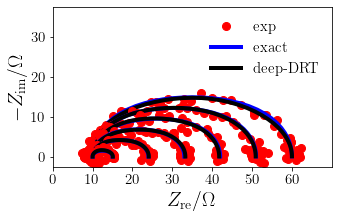

In [16]:
# first step is look at the distance
distance_vec = np.zeros(len(x_NN_store))

for iter_pt in range(len(x_NN_store)):
    distance_loc = 0.

    for index in range(len(T_range)):
        # collect the gamma from the results
        x = x_NN_store[iter_pt, :, index]
        gamma = np.squeeze(x)

        # get the exact gamma
        x = gamma_exact_list[index]
        gamma_exact = np.squeeze(x)

        distance_loc += np.linalg.norm(gamma-gamma_exact)

    distance_vec[iter_pt] = distance_loc

iter_opt = np.argmin(distance_vec)

for index in range(len(T_range)):
    
    if (index+1)%2:
        temp = T_range[index]
        # experimental data
        Z_re_exp = Z_re_list[index]
        Z_im_exp = Z_im_list[index]
        
        # A matrices
        A_re = A_re_list[index]
        A_im = A_im_list[index]
        
        # stored values
        x = x_NN_store[iter_opt, :, index].reshape(N_taus,1)
        R_inf = R_inf_NN_store[iter_opt, index]
    
        # model results
        Z_re_model = R_inf + np.matmul(A_re,x)
        Z_im_model = np.matmul(A_im,x)
      
        if index == 0:
            label_exp = "exp"
            label_exact = 'exact'
            label_DRT = "deep-DRT"
        else:
            label_exp = ''
            label_exact = ''
            label_DRT = ''         
            
        plt.plot(Z_re_exp, -Z_im_exp, "o", markersize=8, color="red", label=label_exp)
        plt.plot(Z_re_exact_list[index], -Z_im_exact_list[index], linewidth=4, color="blue", label=label_exact)
        plt.plot(Z_re_model, -Z_im_model, linewidth=4, color="black", label=label_DRT)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.legend(frameon=False, fontsize = 15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.axis([0,70,-2.5,32.5])
plt.axis([0,70,-2.5,37.5])
plt.xticks(np.arange(0, 70, step=10))
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()

## 3.2) Plot of recovered DRT
### Figure 14(b)

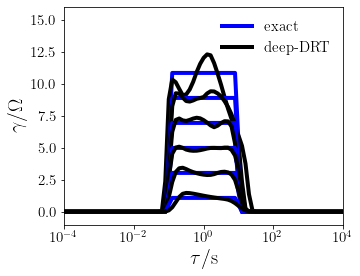

In [17]:
for index in range(len(T_range)):
    
    if (index+1)%2:
        # stored values
        x = x_NN_store[iter_opt, :, index].reshape(N_taus,1)
        gamma = x
        gamma_exact  = gamma_exact_list[index]
        
        if index == 0:
            label_exact = 'exact'
            label_DRT = "deep-DRT"
        else:
            label_exact = ''
            label_DRT = ''      
            
        plt.semilogx(tau_vec, gamma_exact, linewidth=4, color="blue", label=label_exact)
        plt.semilogx(tau_vec, gamma, linewidth=4, color="black", label=label_DRT)
  
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.xlim(1E-4, 1E4)
# plt.ylim(-10, 40)
plt.ylim(-1, 16)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15, loc = "upper right")
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()